# Move qubit along a line

This notebook aims at moving a logical qubit along a line during the logical memory experiment, 
which is depicted in the following figure:

![Move logical qubit along a line](./images/move_qubit_along_a_line/move_qubit_along_z.png)

To be more specific, we want to implement a distance $d$ logical memory experiment with the following steps:

1. Prepare the logical qubit in Z(X) basis and repeat for $t_0 = d$ rounds
2. Extend the qubit along the line in the direction of Z(X) logical operator and repeat for $t_1 = d$ rounds
3. Move the qubit to the destination and repeat for $t_2 = d$ rounds

The above steps will take $3d$ rounds in total. We will compare the logical Z(X) error rate of the above experiment with the logical Z(X) error rate of the standard static logical memory experiment. If the implementation is correct, the logical Z(X) error rate of the above experiment should be at least as good as the logical Z(X) error rate of the standard static logical memory experiment.

> In principle, we should be able to move the qubit for any long distance. However, I found making the move distance generic pose great difficulty in the implementation. Specifically, the overlap between the original qubit and the moved qubit varies with the move distance and code distance, which makes it difficult to build the generic templates. Therefore, we will only consider the case where **the move distance is equal to $d-1$** in this notebook.

## Imports

In [1]:
import functools

import cirq
import matplotlib.pyplot as plt
import sinter
import stim
import numpy as np
from stimcirq import cirq_circuit_to_stim_circuit

from tqec.templates.atomic.square import AlternatingSquareTemplate
from tqec.templates.atomic.rectangle import AlternatingRectangleTemplate
from tqec.templates.scale import Dimension, LinearFunction
from tqec.templates.composed import ComposedTemplate
from tqec.templates.base import TemplateWithIndices
from tqec.display import display_template
from tqec.detectors.gate import ShiftCoordsGate
from tqec.detectors.transformer import fill_in_global_record_indices
from tqec.enums import PlaquetteOrientation, ABOVE_OF, BELOW_OF, LEFT_OF, RIGHT_OF
from tqec.generation.circuit import generate_circuit
from tqec.noise_models import (
    AfterCliffordDepolarizingNoise,
    AfterResetFlipNoise,
    BeforeMeasurementFlipNoise,
)
from tqec.plaquette.schedule import ScheduledCircuit
from tqec.plaquette.plaquette import PlaquetteList
from tqec.plaquette.library import *
from tqec.detectors.gate import ObservableGate, RelativeMeasurement, DetectorGate
from tqec.position import Shape2D
from tqec.display import display_template

## Normalisation and noisyness

Once the quantum error correction circuit implemented, we still need to apply two passes to obtain a circuit ready to be translated by the `stimcirq`.

The first pass normalises the `cirq.Circuit` produced. This pass was performing several modifications before, but is now simply removing potential empty `cirq.Moment` instances from the `cirq.Circuit` instance.

The second pass applies the noise model(s) we want to consider in the `stim` simulation.

In [2]:
def normalise_circuit(circuit: cirq.Circuit) -> cirq.Circuit:
    ordered_transformers = [
        cirq.drop_empty_moments,
    ]
    for transformer in ordered_transformers:
        circuit = transformer(circuit)
    return circuit


def to_noisy_circuit(circuit: cirq.Circuit, noise_level: float) -> cirq.Circuit:
    noise_models = [
        AfterCliffordDepolarizingNoise(noise_level),
        AfterResetFlipNoise(noise_level),
        BeforeMeasurementFlipNoise(noise_level),
    ]
    for nm in noise_models:
        circuit = circuit.with_noise(nm)
    return circuit

## Build the templates

Firstly, we need to build templates for the plaquettes to fit in. Consider moving the qubit from left to right, the `ScalableAlternatingSquare` can not be simply applied since there are overlap between the boundaries of the qubit before and after the movement.

What we want to build is as follows:

![Built template](./images/move_qubit_along_a_line/built_templates.png)

In [3]:
class AlternatingSquareWithOverlap(AlternatingSquareTemplate):
    def __init__(self, dimension: Dimension, overlap_at_tail: bool) -> None:
        super().__init__(dimension)
        self._overlap_at_tail = overlap_at_tail

    def instanciate(
        self,
        x_plaquette: int,
        z_plaquette: int,
        overlap_plaquette1: int,
        overlap_plaquette2: int,
        *_: int,
    ) -> np.ndarray:
        arr = super().instanciate(x_plaquette, z_plaquette, *_)
        col_idx = -1 if self._overlap_at_tail else 0
        arr[::2, col_idx] = overlap_plaquette1
        arr[1::2, col_idx] = overlap_plaquette2
        return arr

In [4]:
def generate_template(k: int) -> ComposedTemplate:
    dim = Dimension(k, LinearFunction(2))
    nsone = Dimension(1, LinearFunction(0, 1))
    _templates = [
        # original square
        TemplateWithIndices(AlternatingSquareWithOverlap(dim, True), [1, 2, 3, 4]),
        # original top boundary
        TemplateWithIndices(AlternatingRectangleTemplate(dim, nsone), [0, 5]),
        # original bottom boundary
        TemplateWithIndices(AlternatingRectangleTemplate(dim, nsone), [6, 0]),
        # original left boundary
        TemplateWithIndices(AlternatingRectangleTemplate(nsone, dim), [7, 0]),
        # moved square
        TemplateWithIndices(AlternatingSquareWithOverlap(dim, False), [8, 9, 10, 11]),
        # moved top boundary
        TemplateWithIndices(AlternatingRectangleTemplate(dim, nsone), [0, 12]),
        # moved bottom boundary
        TemplateWithIndices(AlternatingRectangleTemplate(dim, nsone), [13, 0]),
        # moved right boundary
        TemplateWithIndices(AlternatingRectangleTemplate(nsone, dim), [0, 14]),
    ]
    _relations = [
        (1, ABOVE_OF, 0),
        (2, BELOW_OF, 0),
        (3, LEFT_OF, 0),
        (4, RIGHT_OF, 0),
        (5, ABOVE_OF, 4),
        (6, BELOW_OF, 4),
        (7, RIGHT_OF, 4),
    ]
    template = ComposedTemplate(_templates)
    for source, relpos, target in _relations:
        template.add_relation(source, relpos, target)
    return template

In [5]:
template = generate_template(2)
display_template(template)

  .  .  5  .  5  . 12  . 12  .
  7  1  2  1  3 10  9  8  9  .
  .  2  1  2  4 11  8  9  8 14
  7  1  2  1  3 10  9  8  9  .
  .  2  1  2  4 11  8  9  8 14
  .  6  .  6  . 13  . 13  .  .


## Prepare the plaquettes

Since the logical qubit moves with the time, we cannot use the standard plaquettes from the `tqec` library. Instead, we need to build the plaquettes from the scratch. Start from the circuit overview, we can devide the circuits into the following layers:

1. Initialize the original qubit
2. Do logical memory circuits for $d-1$ rounds
3. Initialize the movement path
4. Do logical memory circuits for $d-1$ rounds
5. Measure the stabilizers and data qubits outside the destination qubit
6. Do logical memory circuits for $d-1$ rounds
7. Measure the destination qubit

We then build the plaquettes according to the layers.

In [6]:
schedule_xxxx = [1, 2, 3, 4, 5, 6, 7, 8]
schedule_zzzz = [1, 3, 4, 5, 6, 8]
schedule_zz_left = [1, 5, 6, 8]
schedule_zz_right = [1, 3, 4, 8]
schedule_xx_up = [1, 2, 5, 6, 7, 8]
schedule_xx_down = [1, 2, 3, 4, 7, 8]

dummy_circuit = lambda: ScheduledCircuit(cirq.Circuit())

PLAQUETTES = [
    # 1
    PlaquetteList(
        [
            XXXXInitialisationPlaquette(schedule_xxxx, include_detector=False),
            XXXXMemoryPlaquette(schedule_xxxx),
            XXXXMemoryPlaquette(schedule_xxxx),
            XXXXMemoryPlaquette(schedule_xxxx),
            XXXXFinalMeasurementPlaquette(include_detector=False),
            BaseXXXXPlaquette(dummy_circuit()),
            BaseXXXXPlaquette(dummy_circuit()),
        ]
    ),
    # 2
    PlaquetteList(
        [
            ZZZZInitialisationPlaquette(schedule_zzzz),
            ZZZZMemoryPlaquette(schedule_zzzz),
            ZZZZMemoryPlaquette(schedule_zzzz),
            ZZZZMemoryPlaquette(schedule_zzzz),
            ZZZZFinalMeasurementPlaquette(),
            BaseZZZZPlaquette(dummy_circuit()),
            BaseZZZZPlaquette(dummy_circuit()),
        ]
    ),
    # 3
    PlaquetteList(
        [
            ZZZZInitialisationPlaquette(schedule_zzzz),
            ZZZZMemoryPlaquette(schedule_zzzz),
            ZZZZMemoryPlaquette(schedule_zzzz),
            ZZZZMemoryPlaquette(schedule_zzzz),
            BaseZZZZPlaquette(dummy_circuit()),
            ZZMemoryPlaquette(PlaquetteOrientation.LEFT, schedule_zz_left),
            ZZFinalMeasurementPlaquette(PlaquetteOrientation.LEFT),
        ]
    ),
    # 4
    PlaquetteList(
        [
            XXXXInitialisationPlaquette(schedule_xxxx, include_detector=False),
            XXXXMemoryPlaquette(schedule_xxxx),
            XXXXMemoryPlaquette(schedule_xxxx),
            XXXXMemoryPlaquette(schedule_xxxx),
            BaseXXXXPlaquette(dummy_circuit()),
            BaseXXXXPlaquette(dummy_circuit()),
            BaseXXXXPlaquette(dummy_circuit()),
        ]
    ),
    # 5
    PlaquetteList(
        [
            XXInitialisationPlaquette(
                PlaquetteOrientation.UP, schedule_xx_up, include_detector=False
            ),
            XXMemoryPlaquette(PlaquetteOrientation.UP, schedule_xx_up),
            XXMemoryPlaquette(PlaquetteOrientation.UP, schedule_xx_up),
            XXMemoryPlaquette(PlaquetteOrientation.UP, schedule_xx_up),
            BaseXXPlaquette(dummy_circuit(), PlaquetteOrientation.UP),
            BaseXXPlaquette(dummy_circuit(), PlaquetteOrientation.UP),
            BaseXXPlaquette(dummy_circuit(), PlaquetteOrientation.UP),
        ]
    ),
    # 6
    PlaquetteList(
        [
            XXInitialisationPlaquette(
                PlaquetteOrientation.DOWN, schedule_xx_down, include_detector=False
            ),
            XXMemoryPlaquette(PlaquetteOrientation.DOWN, schedule_xx_down),
            XXMemoryPlaquette(PlaquetteOrientation.DOWN, schedule_xx_down),
            XXMemoryPlaquette(PlaquetteOrientation.DOWN, schedule_xx_down),
            BaseXXPlaquette(dummy_circuit(), PlaquetteOrientation.DOWN),
            BaseXXPlaquette(dummy_circuit(), PlaquetteOrientation.DOWN),
            BaseXXPlaquette(dummy_circuit(), PlaquetteOrientation.DOWN),
        ]
    ),
    # 7
    PlaquetteList(
        [
            ZZInitialisationPlaquette(
                PlaquetteOrientation.LEFT, schedule_zz_left, include_detector=True
            ),
            ZZMemoryPlaquette(PlaquetteOrientation.LEFT, schedule_zz_left),
            ZZMemoryPlaquette(PlaquetteOrientation.LEFT, schedule_zz_left),
            ZZMemoryPlaquette(PlaquetteOrientation.LEFT, schedule_zz_left),
            ZZFinalMeasurementPlaquette(PlaquetteOrientation.LEFT),
            BaseZZPlaquette(dummy_circuit(), PlaquetteOrientation.LEFT),
            BaseZZPlaquette(dummy_circuit(), PlaquetteOrientation.LEFT),
        ]
    ),
    # 8
    PlaquetteList(
        [
            BaseXXXXPlaquette(dummy_circuit()),
            BaseXXXXPlaquette(dummy_circuit()),
            XXXXInitialisationPlaquette(schedule_xxxx, include_detector=False),
            XXXXMemoryPlaquette(schedule_xxxx),
            BaseXXXXPlaquette(dummy_circuit()),
            XXXXMemoryPlaquette(schedule_xxxx),
            XXXXFinalMeasurementPlaquette(include_detector=False),
        ]
    ),
    # 9
    PlaquetteList(
        [
            BaseZZZZPlaquette(dummy_circuit()),
            BaseZZZZPlaquette(dummy_circuit()),
            ZZZZInitialisationPlaquette(schedule_zzzz),
            ZZZZMemoryPlaquette(schedule_zzzz),
            BaseZZZZPlaquette(dummy_circuit()),
            ZZZZMemoryPlaquette(schedule_zzzz),
            ZZZZFinalMeasurementPlaquette(),
        ]
    ),
    # 10
    PlaquetteList(
        [
            BaseXXXXPlaquette(dummy_circuit()),
            BaseXXXXPlaquette(dummy_circuit()),
            XXXXMemoryPlaquette(schedule_xxxx, include_detector=False),
            XXXXMemoryPlaquette(schedule_xxxx),
            BaseXXXXPlaquette(dummy_circuit()),
            XXXXMemoryPlaquette(schedule_xxxx),
            XXXXFinalMeasurementPlaquette(include_detector=False),
        ]
    ),
    # 11
    PlaquetteList(
        [
            ZZInitialisationPlaquette(PlaquetteOrientation.RIGHT, schedule_zz_right),
            ZZMemoryPlaquette(PlaquetteOrientation.RIGHT, schedule_zz_right),
            ZZZZMemoryPlaquette(schedule_zzzz),
            ZZZZMemoryPlaquette(schedule_zzzz),
            BaseZZZZPlaquette(dummy_circuit()),
            ZZZZMemoryPlaquette(schedule_zzzz),
            ZZZZFinalMeasurementPlaquette(),
        ]
    ),
    # 12
    PlaquetteList(
        [
            BaseXXPlaquette(dummy_circuit(), PlaquetteOrientation.UP),
            BaseXXPlaquette(dummy_circuit(), PlaquetteOrientation.UP),
            XXInitialisationPlaquette(
                PlaquetteOrientation.UP, schedule_xx_up, include_detector=False
            ),
            XXMemoryPlaquette(PlaquetteOrientation.UP, schedule_xx_up),
            BaseXXPlaquette(dummy_circuit(), PlaquetteOrientation.UP),
            XXMemoryPlaquette(PlaquetteOrientation.UP, schedule_xx_up),
            XXFinalMeasurementPlaquette(
                PlaquetteOrientation.UP, include_detector=False
            ),
        ]
    ),
    # 13
    PlaquetteList(
        [
            BaseXXPlaquette(dummy_circuit(), PlaquetteOrientation.DOWN),
            BaseXXPlaquette(dummy_circuit(), PlaquetteOrientation.DOWN),
            XXMemoryPlaquette(
                PlaquetteOrientation.DOWN, schedule_xx_down, include_detector=False
            ),
            XXMemoryPlaquette(PlaquetteOrientation.DOWN, schedule_xx_down),
            BaseXXPlaquette(dummy_circuit(), PlaquetteOrientation.DOWN),
            XXMemoryPlaquette(PlaquetteOrientation.DOWN, schedule_xx_down),
            XXFinalMeasurementPlaquette(
                PlaquetteOrientation.DOWN, include_detector=False
            ),
        ]
    ),
    # 14
    PlaquetteList(
        [
            BaseZZPlaquette(dummy_circuit(), PlaquetteOrientation.RIGHT),
            BaseZZPlaquette(dummy_circuit(), PlaquetteOrientation.RIGHT),
            ZZInitialisationPlaquette(
                PlaquetteOrientation.RIGHT, schedule_zz_right, include_detector=True
            ),
            ZZMemoryPlaquette(PlaquetteOrientation.RIGHT, schedule_zz_right),
            BaseZZPlaquette(dummy_circuit(), PlaquetteOrientation.RIGHT),
            ZZMemoryPlaquette(PlaquetteOrientation.RIGHT, schedule_zz_right),
            ZZFinalMeasurementPlaquette(PlaquetteOrientation.RIGHT),
        ]
    ),
]

## Build the circuit

In [7]:
def build_circuit(d: int) -> cirq.Circuit:
    k = (d - 1) // 2
    template = generate_template(k)

    # repeat memory cycles
    def make_repeated_layer(circuit: cirq.Circuit, repetitions: int) -> cirq.Circuit:
        any_qubit = next(iter(circuit.all_qubits()), None)
        assert (
            any_qubit is not None
        ), "Could not find any qubit in the given Circuit instance."
        circuit_to_repeat = (
            cirq.Circuit([ShiftCoordsGate(0, 0, 1).on(any_qubit)]) + circuit
        )
        repeated_circuit_operation = cirq.CircuitOperation(
            circuit_to_repeat.freeze()
        ).repeat(repetitions)
        return cirq.Circuit([repeated_circuit_operation])

    # the left boundary Z stabilizers of moved qubit should modify the detectors
    # once the data qubits along the path are measured
    def modify_detector_then_repeat(circuit: cirq.Circuit) -> cirq.Circuit:
        replacements = []
        syndrome_qubits = [
            cirq.GridQubit(row, 2 * d - 1) for row in range(3, 3 + (d - 1) * 2, 4)
        ]
        for moment_idx, op in circuit.findall_operations(
            lambda op: isinstance(op.gate, DetectorGate)
            and op.qubits[0] in syndrome_qubits
        ):
            syndrome_qubit = op.sub_operation.gate._qubit_coordinate_system_origin
            new_detector_op = DetectorGate(
                syndrome_qubit,
                [
                    RelativeMeasurement(cirq.GridQubit(0, 0), -1),
                    RelativeMeasurement(cirq.GridQubit(0, 0), -2),
                    RelativeMeasurement(cirq.GridQubit(-1, -1), -1),
                    RelativeMeasurement(cirq.GridQubit(1, -1), -1),
                ],
            ).on(syndrome_qubit)
            replacements.append((moment_idx, op, new_detector_op))
        replaced_circuit = circuit.copy()
        replaced_circuit.batch_replace(replacements)
        if d > 3:
            replaced_circuit += make_repeated_layer(circuit, d - 2)
        else:
            replaced_circuit += circuit
        return replaced_circuit

    layer_modificators = {
        1: functools.partial(make_repeated_layer, repetitions=d - 1),
        3: functools.partial(make_repeated_layer, repetitions=d - 1),
        5: modify_detector_then_repeat,
    }

    circuit = cirq.Circuit()
    for layer_index in range(7):
        layer_circuit = generate_circuit(
            template,
            [plaquette_list.plaquettes[layer_index] for plaquette_list in PLAQUETTES],
        )
        layer_circuit = normalise_circuit(layer_circuit)
        circuit += layer_modificators.get(layer_index, lambda circ: circ)(layer_circuit)

    # add the observable
    origin = cirq.GridQubit(d + 1, 2)
    circuit.append(
        [
            ObservableGate(
                origin,
                [
                    RelativeMeasurement(cirq.GridQubit(0, 2 * i), -1)
                    for i in range(2 * (d - 1) + 1)
                ],
            ).on(origin)
        ],
        cirq.InsertStrategy.INLINE,
    )

    circuit_with_detectors = fill_in_global_record_indices(circuit)
    return circuit_with_detectors

In [8]:
def generate_stim_circuit_tqec(d: int, noise_level: float = 0.0) -> stim.Circuit:
    circuit = build_circuit(d)
    if abs(noise_level) > 1e-12:
        circuit = to_noisy_circuit(circuit, noise_level)
    return cirq_circuit_to_stim_circuit(circuit)

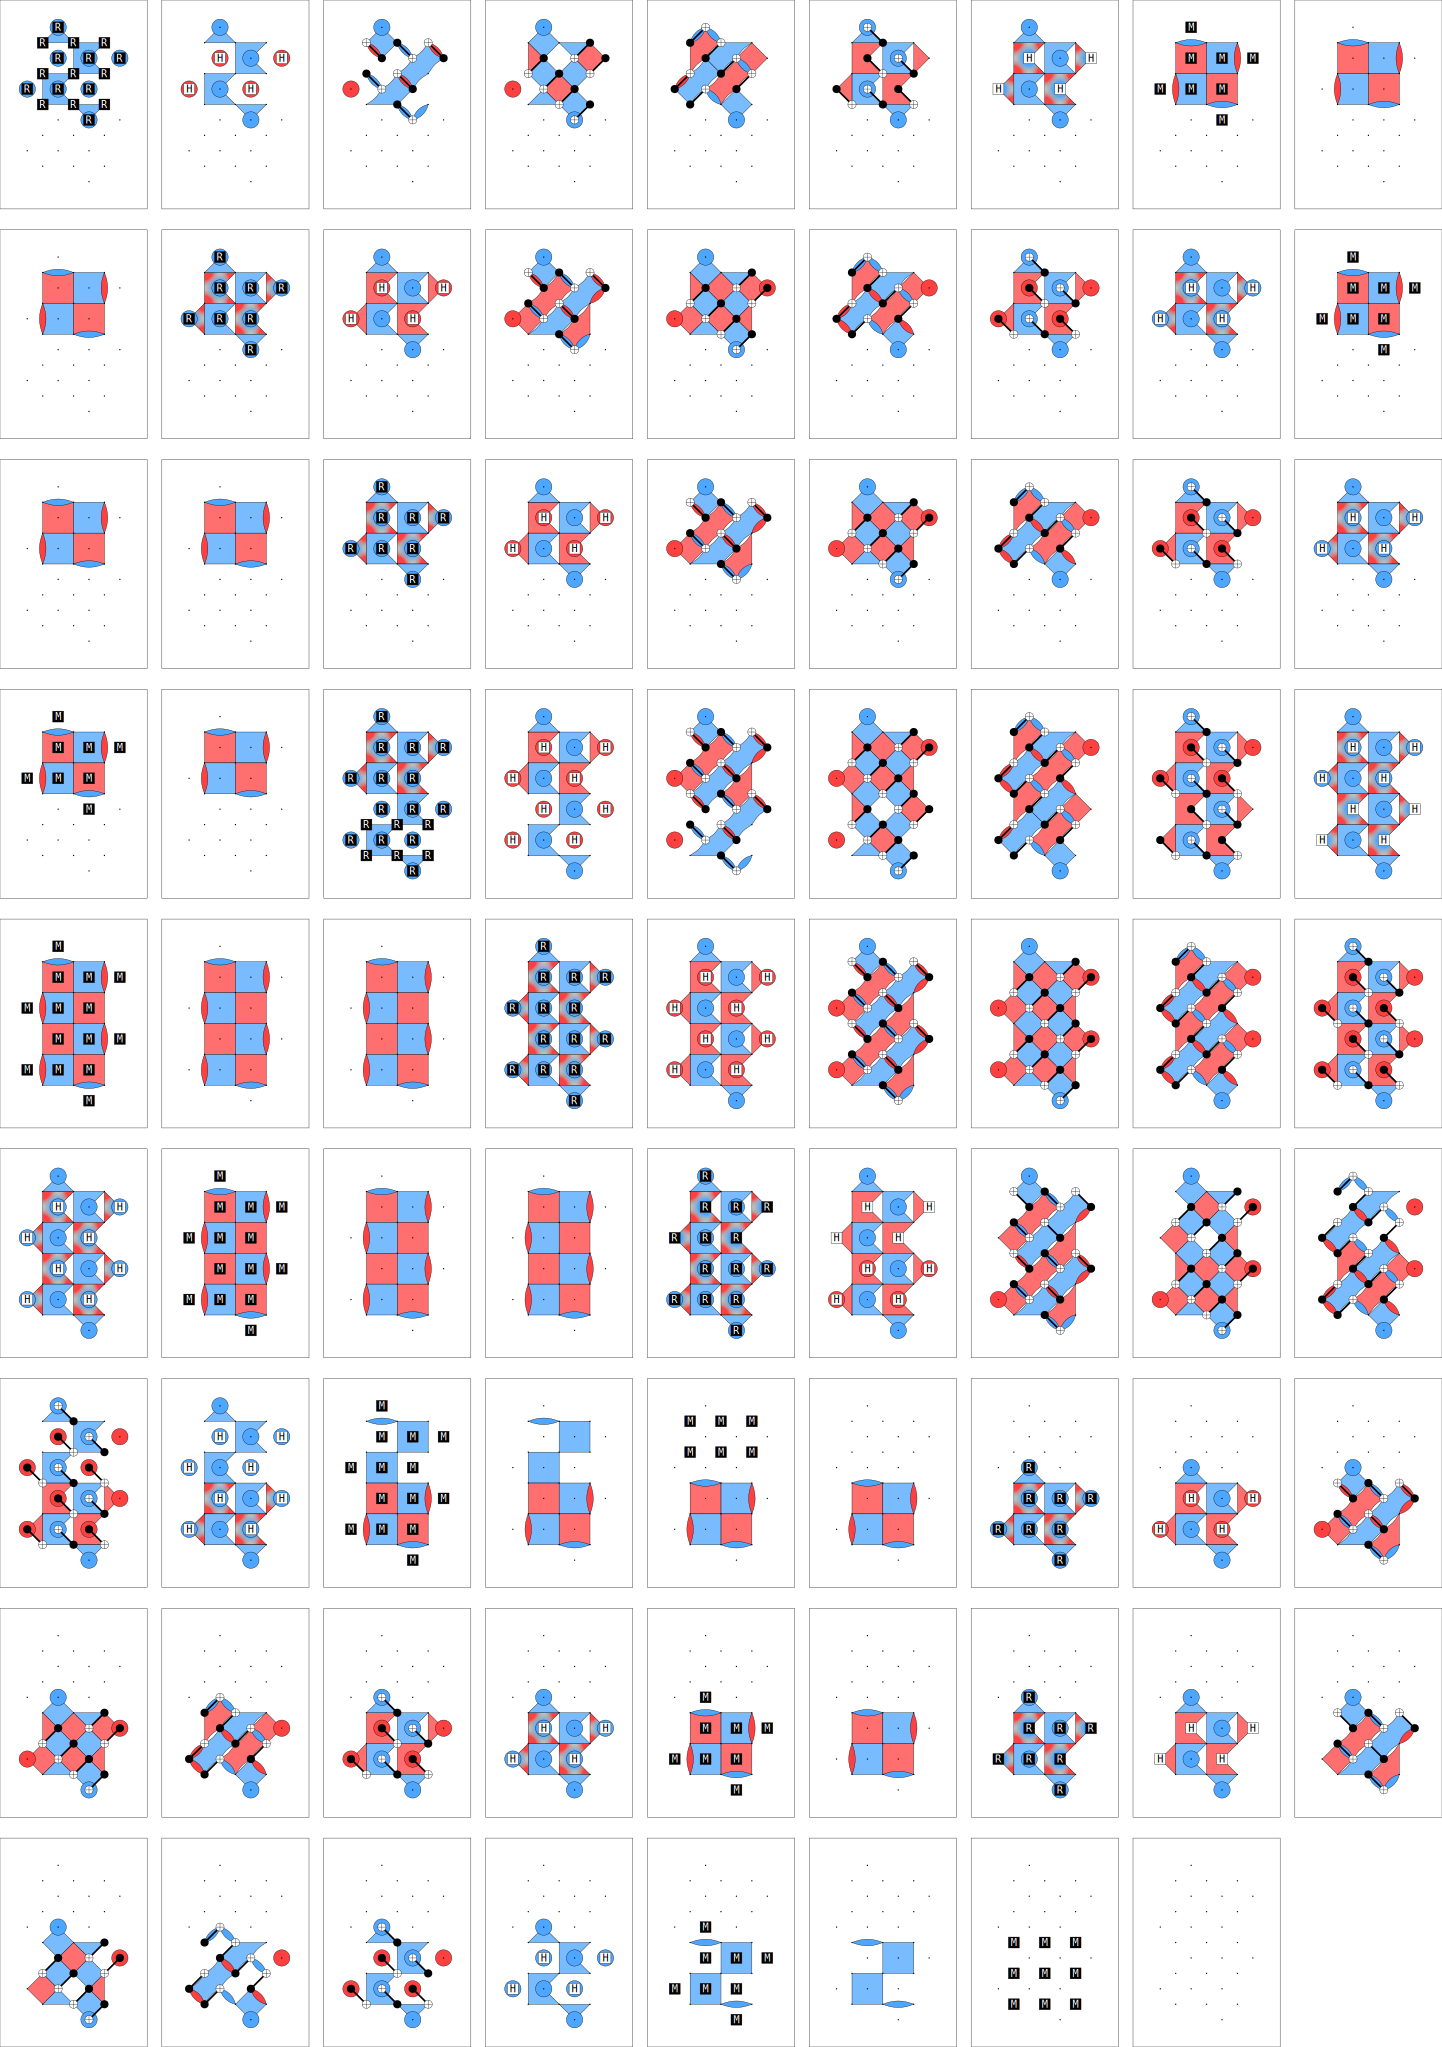

In [9]:
stim_circuit = generate_stim_circuit_tqec(3)
stim_circuit.diagram(type="detslice-with-ops-svg")

## Simulation

In [10]:
surface_code_tasks_tqec = [
    sinter.Task(
        circuit=generate_stim_circuit_tqec(d, noise),
        json_metadata={"d": d, "r": 3 * d, "p": noise},
    )
    for d in [3, 5, 7, 9, 11]
    for noise in [0.001, 0.002, 0.005, 0.01, 0.012, 0.014]
]

collected_surface_code_stats_tqec: list[sinter.TaskStats] = sinter.collect(
    num_workers=20,
    tasks=surface_code_tasks_tqec,
    decoders=["pymatching"],
    max_shots=1_000_000,
    max_errors=5_000,
    print_progress=False,
)

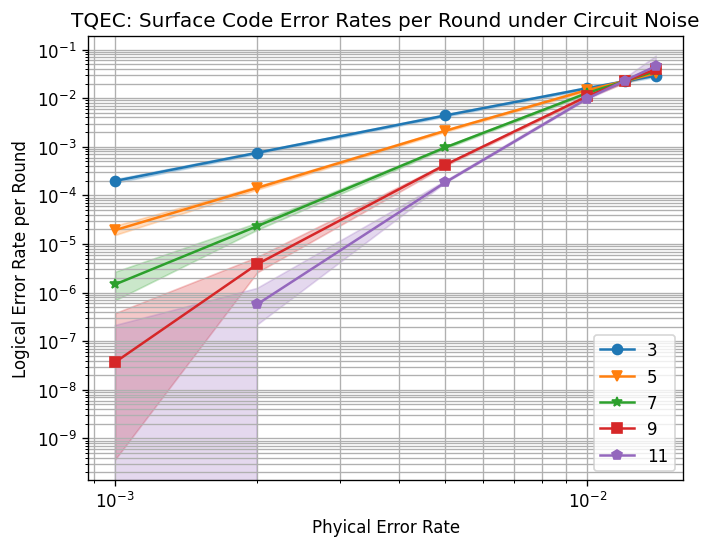

In [11]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=collected_surface_code_stats_tqec,
    x_func=lambda stat: stat.json_metadata["p"],
    group_func=lambda stat: stat.json_metadata["d"],
    failure_units_per_shot_func=lambda stat: stat.json_metadata["r"],
)
ax.loglog()
ax.set_title("TQEC: Surface Code Error Rates per Round under Circuit Noise")
ax.set_xlabel("Phyical Error Rate")
ax.set_ylabel("Logical Error Rate per Round")
ax.grid(which="major")
ax.grid(which="minor")
ax.legend()
fig.set_dpi(120)  # Show it bigger